### Imports

In [1]:
import json
import tensorflow as tf
import keras as kr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

### Constants

In [2]:
IMG_HEIGHT = 28
IMG_WIDTH = 28

LABELS = [
    "T-Shirt/Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Boot"
]

BIN_LABELS = [
    "Clothing",
    "Footwear & Bags"
]

N_CLASSES = len(LABELS)
N_BIN_CLASSES = len(BIN_LABELS) - 1

MULTICLASS_WEIGHTS_FILENAME = "models/best_multiclass_model.weights.h5"
BIN_WEIGHTS_FILENAME = "models/best_binary_model.weights.h5"

MULTICLASS_HYPERPARAMS_FILENAME = "models/best_multiclass_model.hyperparams.json"
BIN_HYPERPARAMS_FILENAME = "models/best_binary_model.hyperparams.json"

SEED = 12345

## Test Samples Loading

In [3]:
# Load dataset FASHION_MNIST
dataset = kr.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = dataset.load_data()
x_test = x_test / 255.

# Binarize and split labels into training and validation
y_test_bin = np.where(np.isin(y_test, [0, 1, 2, 3, 4, 6]), 0, 1)

# One-hot encode labels
y_test_mx = kr.utils.to_categorical(y_test, N_CLASSES)

## Load ANN Models

In [4]:
# Network models initialization
initializer = kr.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=SEED)

# Declare models
multiclass_fashion_model = kr.Sequential([
    kr.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT)),
    kr.layers.Flatten(),
    kr.layers.Dense((IMG_WIDTH * IMG_HEIGHT + N_CLASSES) * 2 // 3, activation='relu', kernel_initializer=initializer),
    kr.layers.Dense(N_CLASSES, activation='softmax', kernel_initializer=initializer)
], name="Fashion_MNIST_Multiclass_Model")


binary_fashion_model = kr.Sequential([
    kr.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT)),
    kr.layers.Flatten(),
    kr.layers.Dense((IMG_WIDTH * IMG_HEIGHT + N_BIN_CLASSES) * 2 // 3, activation='relu', kernel_initializer=initializer),
    kr.layers.Dense(N_BIN_CLASSES, activation='sigmoid', kernel_initializer=initializer)
], name="Fashion_MNIST_Binary_Model")

# Load weights
multiclass_fashion_model.load_weights(MULTICLASS_WEIGHTS_FILENAME)
binary_fashion_model.load_weights(BIN_WEIGHTS_FILENAME)

# Load best parameters
with open(MULTICLASS_HYPERPARAMS_FILENAME, "r") as file:
    multiclass_best_params = json.load(file)

with open(BIN_HYPERPARAMS_FILENAME, "r") as file:
    bin_best_params = json.load(file)

# Compile models
multiclass_fashion_model.compile(
    loss="categorical_crossentropy",
    optimizer=kr.optimizers.Adam(learning_rate=multiclass_best_params["model__learning_rate"]),
    metrics=["accuracy"]
)

binary_fashion_model.compile(
    loss="binary_crossentropy",
    optimizer=kr.optimizers.Adam(learning_rate=bin_best_params["model__learning_rate"]),
    metrics=["accuracy"]
)

2025-03-04 20:20:50.434025: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-04 20:20:50.434053: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-04 20:20:50.434057: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1741119650.434516 2285670 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1741119650.434851 2285670 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Multiclass model prediction binarized

In [5]:
# Predict the test set
y_pred_m_bin = multiclass_fashion_model.predict(x_test, verbose=0)
y_pred_m_bin = np.argmax(y_pred_m_bin, axis=1)

# Binarize the predictions
y_pred_m_bin = np.where(np.isin(y_pred_m_bin, [0, 1, 2, 3, 4, 6]), 0, 1)

# Evaluate the model
bin_multiclass_test_loss, bin_multiclass_test_acc = multiclass_fashion_model.evaluate(x_test, y_test_mx, verbose=0)

# Calculate the confusion matrix
bin_multiclass_cm = confusion_matrix(y_test_bin, y_pred_m_bin)

# Calculate recall and precision metrics
bin_multiclass_recall = np.diag(bin_multiclass_cm) / np.sum(bin_multiclass_cm, axis=1)
bin_multiclass_precision = np.diag(bin_multiclass_cm) / np.sum(bin_multiclass_cm, axis=0)

2025-03-04 20:20:50.655768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


### Binary model prediction

In [6]:
# Predict the test set
y_pred_bin = binary_fashion_model.predict(x_test, verbose=0)

# Higher greater or equal to 0.5 the model predicts Footwear & Bags, lower than 0.5, Clothing is predicted
y_pred_bin = np.where(y_pred_bin >= 0.5, 1, 0)

# Evaluate the model
bin_test_loss, bin_test_acc = binary_fashion_model.evaluate(x_test, y_test_bin, verbose=0)

# Calculate the confusion matrix
bin_cm = confusion_matrix(y_test_bin, y_pred_bin)

# Calculate recall and precision metrics
bin_recall = np.diag(bin_cm) / np.sum(bin_cm, axis=1)
bin_precision = np.diag(bin_cm) / np.sum(bin_cm, axis=0)

## Model Evaluation

In [7]:
results_table = pd.DataFrame({
    'Model': ['Multiclass binarized', 'Binary'],
    'Test Loss': np.round([bin_multiclass_test_loss, bin_test_loss], 4),
    'Test Accuracy': np.round([bin_multiclass_test_acc, bin_test_acc], 4)
})

results_table

,Model,Test Loss,Test Accuracy
0,Multiclass binarized,0.4376,0.8467
1,Binary,0.0368,0.9902


### Models recall and precision

In [8]:
# Create a table to show each label's recall and precision
recall_precision_table = pd.DataFrame({
    'Model': ['Multiclass binarized', 'Binary'],
    'Label': BIN_LABELS,
    'Recall (%)': np.round(np.multiply([np.mean(bin_multiclass_recall), np.mean(bin_recall)], 100), 1),
    'Precision (%)': np.round(np.multiply([np.mean(bin_multiclass_precision), np.mean(bin_precision)], 100), 1)
})

recall_precision_table

,Model,Label,Recall (%),Precision (%)
0,Multiclass binarized,Clothing,99.0,99.0
1,Binary,Footwear & Bags,99.0,99.0


### Models confusion matrix

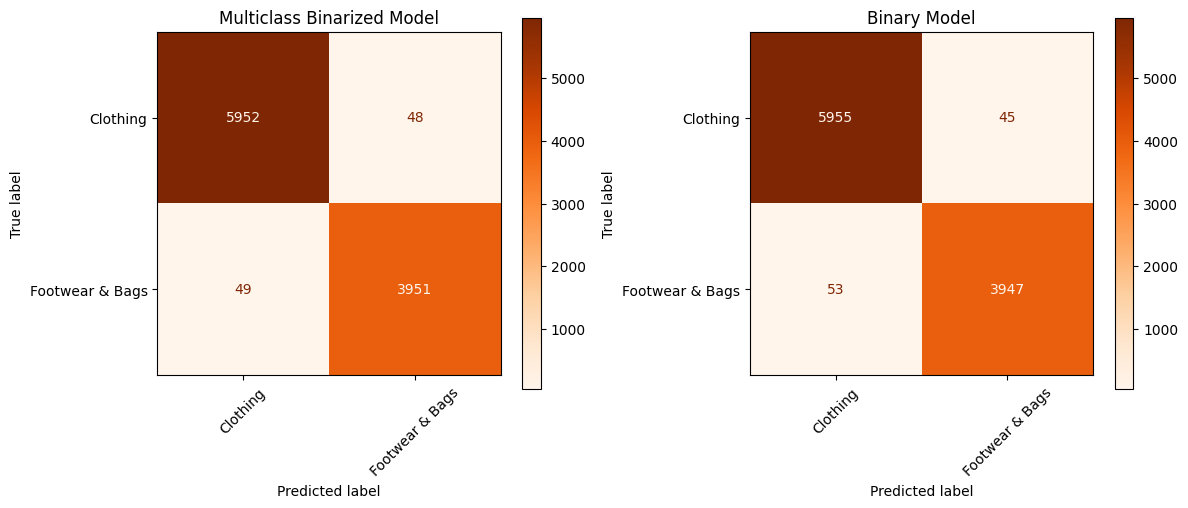

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(bin_multiclass_cm, display_labels=["Clothing", "Footwear & Bags"]).plot(cmap=plt.colormaps['Oranges'], xticks_rotation=45, ax=ax[0])
ax[0].set_title('Multiclass Binarized Model')

ConfusionMatrixDisplay(bin_cm, display_labels=["Clothing", "Footwear & Bags"]).plot(cmap=plt.colormaps['Oranges'], xticks_rotation=45, ax=ax[1])
ax[1].set_title('Binary Model')

plt.tight_layout()
plt.show()

## Analysis

Comparing both the multiclass binarized model and the binary model, their performances are very similar. Considering this, there is no conclusive evidence that one model is superior to the other. This result might vary with each training session due to the randomness associated with weight initialization.

Therefore, it is safe to assume that binarizing the data and training a binary model, or training a multiclass model and binarizing the output, are equivalent approaches. This is supported by the recall, precision metrics, as well as the confusion matrices.